In [2]:
import ROOT
from array import array
import numpy as np
import scipy
import copy
import matplotlib.path as mpath
import matplotlib.pyplot as plt

Welcome to JupyROOT 6.22/06


Matplotlib created a temporary config/cache directory at /tmp/matplotlib-t4umb0y6 because the default path (/home/jovyan/.cache/matplotlib) is not a writable directory; it is highly recommended to set the MPLCONFIGDIR environment variable to a writable directory, in particular to speed up the import of Matplotlib and to better support multiprocessing.


# New plotting code

In [3]:
# Function to generate logarithmically spaced bins
def logspace_bins(start, stop, num):
    return np.logspace(np.log10(start), np.log10(stop), num)

In [4]:
def create_boundary_tgraph(boundary_exprs, n_points=1000,repl=["x","Q2"]):
    # Define the range of x and y values
    if(repl==["x","Q2"]):
        x_vals = np.linspace(0, 1, 1000)
        y_vals = np.linspace(0, 20, 1000)
    elif(repl==["z","pTtot"]):
        x_vals = np.linspace(-0.1, 1.1, 1000)
        y_vals = np.linspace(-0.1, 3, 1000)
    else:
        x_vals = np.linspace(0, 1, 1000)
        y_vals = np.linspace(0, 20, 1000)
    # Create a meshgrid from x and y values
    x, y = np.meshgrid(x_vals, y_vals)

    # Evaluate the inequalities for each point in the meshgrid
    ineq = np.ones_like(x, dtype=bool)
    for inequality in boundary_exprs:
        inequality=inequality.replace(repl[1],"y").replace(repl[0],"x")
        ineq = np.logical_and(ineq, eval(inequality))

    # Define the levels of the contour plot
    levels = [0.5, 1]

    # Create a contour plot of the inequalities
    contour_data= plt.contour(x, y, ineq, levels=levels, colors='k')
    # Hide the plot
    plt.close()
    xy_points = np.array(contour_data.collections[0].get_paths()[0].vertices)
    x=xy_points[:,0]
    y=xy_points[:,1]
    
    # Create the TGraph object
    graph = ROOT.TGraph(len(x), array('d', x), array('d', y))

    # Set the title and axis labels
    graph.SetTitle("My Graph")
    graph.GetXaxis().SetTitle("X Axis")
    graph.GetYaxis().SetTitle("Y Axis")
    graph.SetLineColor(1)
    graph.SetLineWidth(2)
    
    return graph

In [5]:
def generate_input_boundaries(x_bins, add_middle_cut):
    low_Q2_cut = "Q2>0.9253 + 3.8613 * x + -9.4351 * x*x + 16.9292 * x*x*x + 17.2332 * x*x*x*x"
    middle_Q2_cut="0.6361935324019532 + 5.961630973508846*x + 12.028695097029118*x*x"
    high_Q2_cut = "Q2<x*17"
    input_boundaries = []
    
    for i in range(len(x_bins)):
        x_min=x_bins[i][0]
        x_max=x_bins[i][1]
        input_boundary = [f"x<={x_max}", f"x>={x_min}"]
        if(add_middle_cut[i]==-1):
            input_boundary.append(f"Q2<{middle_Q2_cut}")
        elif(add_middle_cut[i]==1):
            input_boundary.append(f"Q2>{middle_Q2_cut}")
        input_boundary.append(high_Q2_cut)
        input_boundary.append(low_Q2_cut)
        input_boundaries.append(input_boundary)
        
    return input_boundaries

In [6]:
def create_tpave_text(i, btgraph,textsize):
    x_min = y_min = float('inf')
    x_max = y_max = float('-inf')

    x_center = 0
    y_center = 0

    N = btgraph.GetN()
    for j in range(N):
        x = btgraph.GetPointX(j)
        y = btgraph.GetPointY(j)

        x_min = min(x_min, x)
        x_max = max(x_max, x)
        y_min = min(y_min, y)
        y_max = max(y_max, y)

        x_center += x / N
        y_center += y / N

    tpave = ROOT.TPaveText(x_center - 0, y_center - 0, x_center + 0, y_center + 0)
    tpave.SetTextSize(textsize)
    tpave.AddText(str(i))
    tpave.SetTextColor(2)
    tpave.Draw("same")

    return copy.deepcopy(tpave)

In [7]:
def get_tgraph_boundaries(input_boundaries,repl=["x","Q2"]):
    btgraphs=[]
    for b in input_boundaries:
        btgraph = create_boundary_tgraph(b,1000,repl)
        btgraphs.append(btgraph)
    return copy.deepcopy(btgraphs)

In [16]:

def get_hists(infile,xQ2_boundaries, zpT_boundaries, var1, var2, var1_bins, var2_bins, var3, var3_bins, var4=None, var4_bins=None):

    # define cut conditions
    cut_conditions = "xF1>0&&xF2>0&&z<0.95&&Mx>1.5"
    
    # create RDataFrame and select events that satisfy the cut conditions
    df = ROOT.RDataFrame("dihadron", infile)
    df_cut = df.Filter(cut_conditions)

    # create main histogram
    main_hist = df_cut.Histo2D((f"h2d_main_{var1}_{var2}", f"{var1}-{var2} distribution", len(var1_bins) - 1, array('d', var1_bins), len(var2_bins) - 1, array('d', var2_bins)), var1,var2)
    
    var1_var2_hists = []
    var3_var4_hists = []
    var3_var4_subhists = []
    
    tmp_df_cuts=[]
    for idx, b in enumerate(xQ2_boundaries):
        print(idx + 1, "of", len(xQ2_boundaries))
        tmp_df_cut=df_cut.Filter("&&".join(b))
        tmp_df_cuts.append(tmp_df_cut)
        
        # create histogram for var1 and var2
        h2d_var1_var2 = tmp_df_cuts[-1].Histo2D((f"h2d_{var1}_{var2}_{idx}", f"{var1}-{var2} distribution", len(var1_bins) - 1, array('d', var1_bins), len(var2_bins) - 1, array('d', var2_bins)), var1,var2)
        
        var1_var2_hists.append(h2d_var1_var2)

        h2d_var3_var4 = tmp_df_cuts[-1].Histo2D((f"h2d_{var3}_{var4}_{idx}", f"{var3}-{var4} distribution", len(var3_bins) - 1, array('d', var3_bins), len(var4_bins) - 1, array('d', var4_bins)), var3,var4)
            
        var3_var4_hists.append(h2d_var3_var4)
        
        var3_var4_subhists_arr=[]
        
        for idxidx,bb in enumerate(zpT_boundaries):
            tmptmp_df_cut = tmp_df_cut.Filter("&&".join(bb))
            tmp_df_cuts.append(tmptmp_df_cut)
            h2d_var3_var4_sub = tmp_df_cuts[-1].Histo2D((f"h2d_{var3}_{var4}_{idx}_sub", f"{var3}-{var4} distribution", len(var3_bins) - 1, array('d', var3_bins), len(var4_bins) - 1, array('d', var4_bins)), var3,var4)
            var3_var4_subhists_arr.append(h2d_var3_var4_sub)
    
        var3_var4_subhists.append(var3_var4_subhists_arr)
        
    # force z-axis to be identical to main hist
    zmin = main_hist.GetMinimum()
    zmax = main_hist.GetMaximum()
    
    for h in var1_var2_hists:
        h.SetMinimum(zmin)
        h.SetMaximum(zmax)
    
    return main_hist.GetValue(), [h.GetValue() for h in var1_var2_hists], [h.GetValue() for h in var3_var4_hists], [[h.GetValue() for h in hlist] for hlist in var3_var4_subhists]


In [9]:
def get_hists(input_boundaries, var1, var2, var1_bins, var2_bins, var3, var3_bins, var4=None, var4_bins=None, Nmax=1e5):
    Nmax = int(Nmax)
    
    cut_conditions = "xF1>0&&xF2>0&&z<0.95&&Mx>1.5"
    main_hist = ROOT.TH2D(f"h2d_main_{var1}_{var2}", f"{var1}-{var2} distribution", len(var1_bins) - 1, array('d', var1_bins), len(var2_bins) - 1, array('d', var2_bins))
    t.Draw(f"{var2}:{var1}>>h2d_main_{var1}_{var2}", cut_conditions, "goff", Nmax)
    
    var1_var2_hists = []
    var3_var4_hists = []
    
    for idx, b in enumerate(input_boundaries):
        print(idx + 1, "of", len(input_boundaries))
        bcut_conditions = " && ".join(b) + "&&" + cut_conditions
        
        h2d_var1_var2 = ROOT.TH2D(f"h2d_{var1}_{var2}_{idx}", f"{var1}-{var2} distribution", len(var1_bins) - 1, array('d', var1_bins), len(var2_bins) - 1, array('d', var2_bins))
        t.Draw(f"{var2}:{var1}>>h2d_{var1}_{var2}_{idx}", bcut_conditions, "goff", Nmax)
        
        # force z-axis to be identical to main hist
        h2d_var1_var2.SetMinimum(main_hist.GetMinimum())
        h2d_var1_var2.SetMaximum(main_hist.GetMaximum())
        
        var1_var2_hists.append(h2d_var1_var2)
        
        if var4 is not None and var4_bins is not None:
            h2d_var3_var4 = ROOT.TH2D(f"h2d_{var3}_{var4}_{idx}", f"{var3}-{var4} distribution", len(var3_bins) - 1, array('d', var3_bins), len(var4_bins) - 1, array('d', var4_bins))
            t.Draw(f"{var4}:{var3}>>h2d_{var3}_{var4}_{idx}", bcut_conditions, "goff", Nmax)
            var3_var4_hists.append(h2d_var3_var4)
        else:
            h1d_var3 = ROOT.TH1D(f"h1d_{var3}_{idx}", f"{var3} distribution", len(var3_bins) - 1, array('d', var3_bins))
            t.Draw(f"{var3}>>h1d_{var3}_{idx}", bcut_conditions, "goff", Nmax)
            var3_var4_hists.append(h1d_var3)
    
    return copy.deepcopy(main_hist), copy.deepcopy(var1_var2_hists), copy.deepcopy(var3_var4_hists)


In [10]:
def generate_z_pt_boundaries(z_edges, pT_edges):
    boundaries = []
    nzbins = len(z_edges) - 1
    npTbins = len(pT_edges) - 1

    for iz in range(nzbins):
        for ip in range(npTbins):
            boundaries.append([f"z>={z_edges[iz]}", f"z<{z_edges[iz+1]}", f"pTtot>={pT_edges[ip]}", f"pTtot<{pT_edges[ip+1]}"])

    return boundaries

In [11]:
def create_info_box(histogram):
    # get number of entries and average x and y values
    n_entries = histogram.GetEntries()
    mean_x = histogram.GetMean(1)
    mean_y = histogram.GetMean(2)

    # create TPaveText object
    text_box = ROOT.TPaveText(0.16, 0.625, 0.5, 0.85, "NDC")  # x1, y1, x2, y2
    text_box.SetTextSize(0.04)
    text_box.SetTextAlign(11)  # set text alignment to left-justified
    text_box.SetTextFont(42)  # set font to normal weight
    #text_box.SetFillColor(ROOT.kWhite)
    #text_box.SetBorderSize(0)

    # add text with information
    text_box.AddText(f"Evts: {n_entries:.2e}")
    text_box.AddText(f"<x>: {mean_x:.3f}")
    text_box.AddText(f"<Q^{{2}}>: {mean_y:.3f} [GeV^{{2}}]")

    return copy.deepcopy(text_box)

In [19]:
def gen_canvas(xQ2_boundaries=[], zpT_boundaries=[], boundary_idx=None, h_xQ2=None, h_xQ2_list=None, h_zpT_list=None, h_zpT_sublist=None):

    xQ2_tgraphs = get_tgraph_boundaries(xQ2_boundaries,["x","Q2"])
    zpT_tgraphs = get_tgraph_boundaries(zpT_boundaries,["z","pTtot"])
    
    # Create a canvas and divide it into two pads for x-Q2 and z-pT histograms
    c = ROOT.TCanvas("c", "x-Q2 distribution", 1200, 600)
    c.Divide(2, 1)

    # Prepare x-Q2 histogram for selected region with log scale axes
    c.cd(1)
    ROOT.gPad.SetLogx()
    ROOT.gPad.SetLogy()
    ROOT.gPad.SetRightMargin(0.15)
    h2d_xQ2 = h_xQ2_list[boundary_idx]
    prepare_hist(h2d_xQ2, ";x;Q^{2} [GeV]", 50)
    h2d_xQ2.Draw("colz")
    text_box = create_info_box(h2d_xQ2)
    text_box.Draw()
    # Draw boundaries on x-Q2 histogram
    for xQ2_tgraph in xQ2_tgraphs:
        xQ2_tgraph.Draw("L same")

    # Create z-pT histogram for selected region
    h2d_zpT = h_zpT_list[boundary_idx]
    h2d_zpT_sublist = h_zpT_sublist[boundary_idx]
    
    # Prepare z-pT histogram with log scale axes
    c.cd(2)
    ROOT.gPad.SetRightMargin(0.15)
    prepare_hist(h2d_zpT, "z pT distribution;z;p_{T} [GeV]", 50)
    h2d_zpT.Draw("colz")
    
    # Draw boundaries on z-pT histogram
    tpaves_zpT = []
    for i,zpT_tgraph in enumerate(zpT_tgraphs):
        zpT_tgraph.Draw("L same")
        entries=h2d_zpT_sublist[i].GetEntries()
        tpaves_zpT.append(create_tpave_text(str(f"{entries:.0e}"), zpT_tgraph,0.04))
        #tpaves_zpT[-1].Draw("same")
        
    # Draw the x-Q2 histogram with all boundaries shown
    c2 = ROOT.TCanvas("c2", "c2", 600, 600)
    ROOT.gPad.SetLogx()
    ROOT.gPad.SetLogy()

    h2d_xQ2_all = h_xQ2
    prepare_hist(h2d_xQ2_all, ";x;Q^{2} [GeV]", 50)
    h2d_xQ2_all.Draw("colz")
    
    # Draw boundaries and add labels on x-Q2 histogram
    tpaves_xQ2 = []
    for i,xQ2_tgraph in enumerate(xQ2_tgraphs):
        xQ2_tgraph.Draw("L same")
        tpaves_xQ2.append(create_tpave_text(i, xQ2_tgraph,0.08))
        tpaves_xQ2[-1].Draw("same")

    return copy.deepcopy(c), copy.deepcopy(c2)


def prepare_hist(hist, title, num_contours):
    """Prepare histogram with specified title, number of contours, and without stats."""
    hist.SetTitle(title)
    hist.SetContour(num_contours)
    hist.SetStats(0)


In [22]:
# Define the boundary expressions
xQ2_boundaries = generate_input_boundaries([[0.07,0.12],[0.12,0.2],[0.2,0.275],[0.275,0.42],[0.42,1],
                                              [0.12,0.15],[0.15,0.22],[0.22,0.29],[0.29,0.42]],
                                             [0,-1,-1,-1,0,1,1,1,1])

zpT_boundaries = generate_z_pt_boundaries([0.15,0.3,0.38,0.5,0.6,0.7,0.95],[0,0.2,0.4,0.6,0.8,1,1.5])

# Example usage
x_bins = logspace_bins(5e-2, 1, 100)
Q2_bins = logspace_bins(1, 20, 100)
z_bins = np.linspace(0, 1, 100)
pt_bins = np.linspace(-0.3, 2, 100)

#infile = "../../projects/ana_v2/volatile/data/piplus_piminus/MC_RGA_3051_0.root"
infile = "../../macros/hipoLUND2tree.root"
xQ2_hist_main, xQ2_hists, zpT_hists, zpT_subhists = get_hists(infile, xQ2_boundaries, zpT_boundaries,"x", "Q2", x_bins, Q2_bins, "z", z_bins, "pTtot", pt_bins)

1 of 9
2 of 9
3 of 9
4 of 9
5 of 9
6 of 9
7 of 9
8 of 9
9 of 9


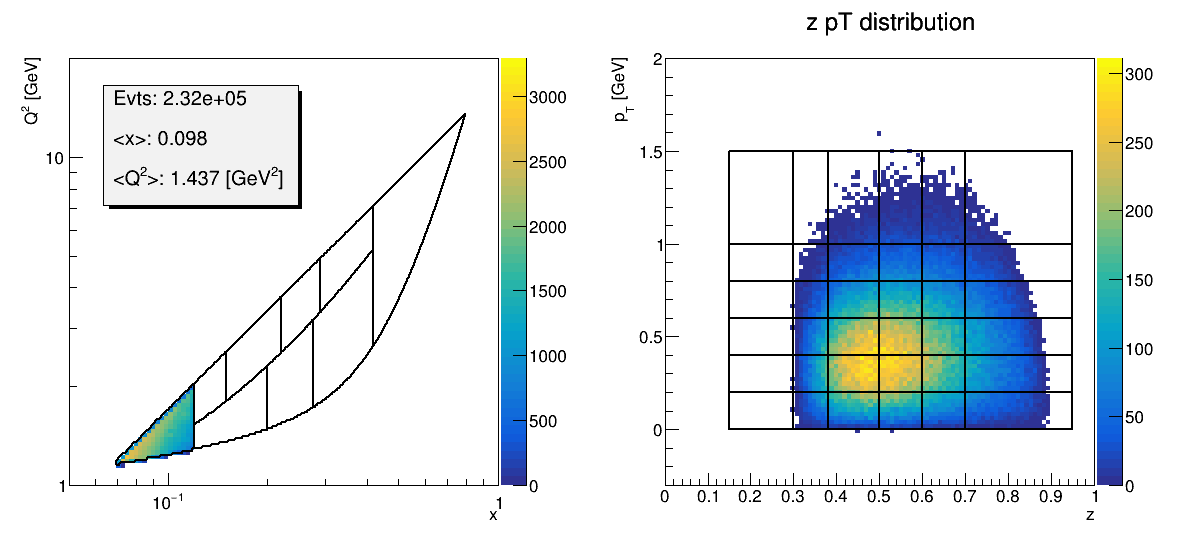

In [23]:
c1,c2=gen_canvas(xQ2_boundaries, zpT_boundaries, 0,xQ2_hist_main, xQ2_hists, zpT_hists, zpT_subhists)
c1.Draw()

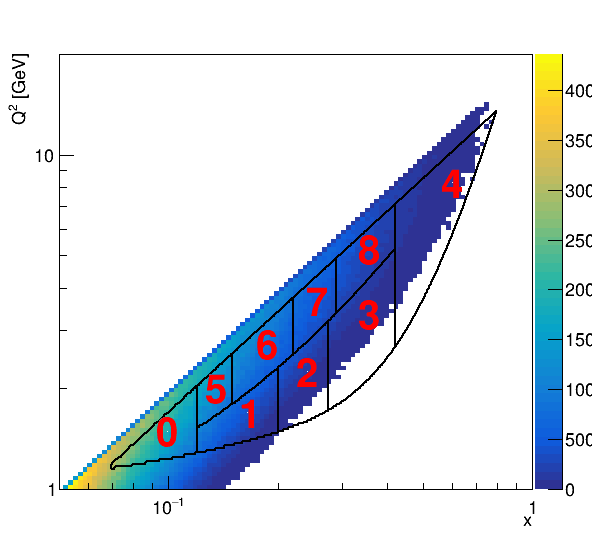

In [21]:
c2.Draw()